In [34]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
# 1a config model

def config_model(degseq):
    ''' 
    Generates a random graph using the configuration model.

    Args:
        degseq (list of int): The desired degree sequence for the graph. 
    
    Returns:
        nx.Graph or None: A NetworkX Graph object if the degree sum is even, otherwise None.
    '''
    G = nx.Graph()
    # creating nodes to populate G with
    n = len(degseq)
    G.add_nodes_from(range(n)) 

    # creating a list of stubs to sample from instead of the nodes
    stubs = [node for node, degree in enumerate(degseq) for _ in range(degree)]

    # handle edge case of uneven deg seq
    if len(stubs) % 2 != 0:
        print("Error: Degree sequence must sum to an even number.")
        return None

    # shuffle list to randomize pairings
    random.shuffle(stubs)

    # pair each adjacent stub
    for i in range(0, len(stubs), 2):
        u = stubs[i]
        v = stubs[i+1]
        G.add_edge(u, v)
        
    return G

In [3]:
# 1b chung lu

def chung_lu(degseq): 
    '''
    Generates a random graph using the Chung-Lu variation of the configuration model.

    Args:
        degseq (list or tuple): A sequence of expected degrees for each node.

    Returns:
        nx.Graph: The generated graph.
    '''
    # same as before
    G = nx.Graph()
    n = len(degseq)
    G.add_nodes_from(range(n))

    # nested for loop to get all possible combos w/o visiting any twice
    degsum = sum(degseq) # 2m = sum of degree sequence
    for i in range(n):
        for j in range(i+1, n):
            ki = degseq[i]
            kj = degseq[j]
            pr = (ki*kj)/degsum # calculate probability
            if random.random()< pr: # add edge based on probability
                G.add_edge(i, j)
    return G

In [4]:
# 1c model diff (setup)

degrees=[8,5,5,4,3,2,2,2,1,1,1,1,1,1,1]
# init lists to contain samples
config_graphs = []
cl_graphs = []

# collecting samples
for i in range(1000):
    G = config_model(degrees)
    config_graphs.append(G)

for i in range(1000):
    G = chung_lu(degrees)
    cl_graphs.append(G)

def avg_adj_matrix(sample):
    ''' 
    Returns the average adjacency matrix from a list of graphs of identical dimension.

    Args:
        sample (list, tuple, or set): Collection of graphs to be averaged.

    Returns:
        avg_matrix (np.ndarray): The average matrix.
    '''
    n = len(degrees)
    sum_matrix = np.zeros((n, n)) # zero matrix to act as "running total"
    for g in sample:
        sum_matrix += nx.to_numpy_array(g) # convert to array and add to sum
    avg_matrix = sum_matrix / len(sample) # calculating avg
    return avg_matrix

# assigning results
config_avg_adj = avg_adj_matrix(config_graphs)
cl_avg_adj = avg_adj_matrix(cl_graphs)



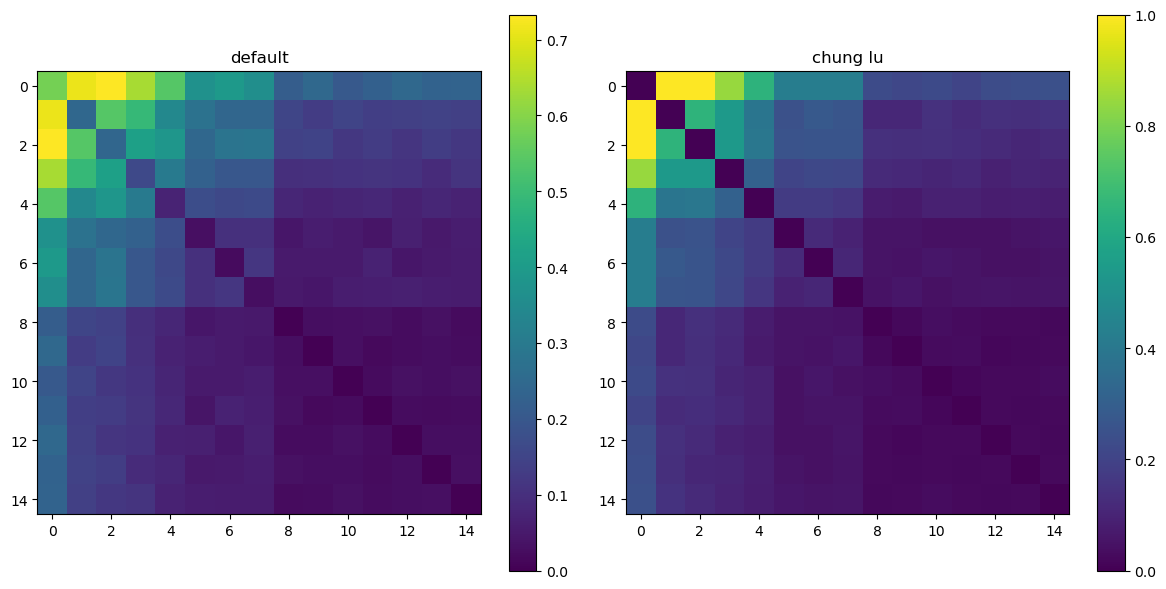

In [5]:
# 1c model diff (heatmap)
fig, ax = plt.subplots(1, 2, figsize=(12,6))

im1 = ax[0].imshow(config_avg_adj, cmap='viridis')
fig.colorbar(im1, ax=ax[0])
ax[0].set_title('default')

im2 = ax[1].imshow(cl_avg_adj, cmap='viridis')
fig.colorbar(im2, ax=ax[1])
ax[1].set_title('chung lu')

plt.tight_layout()

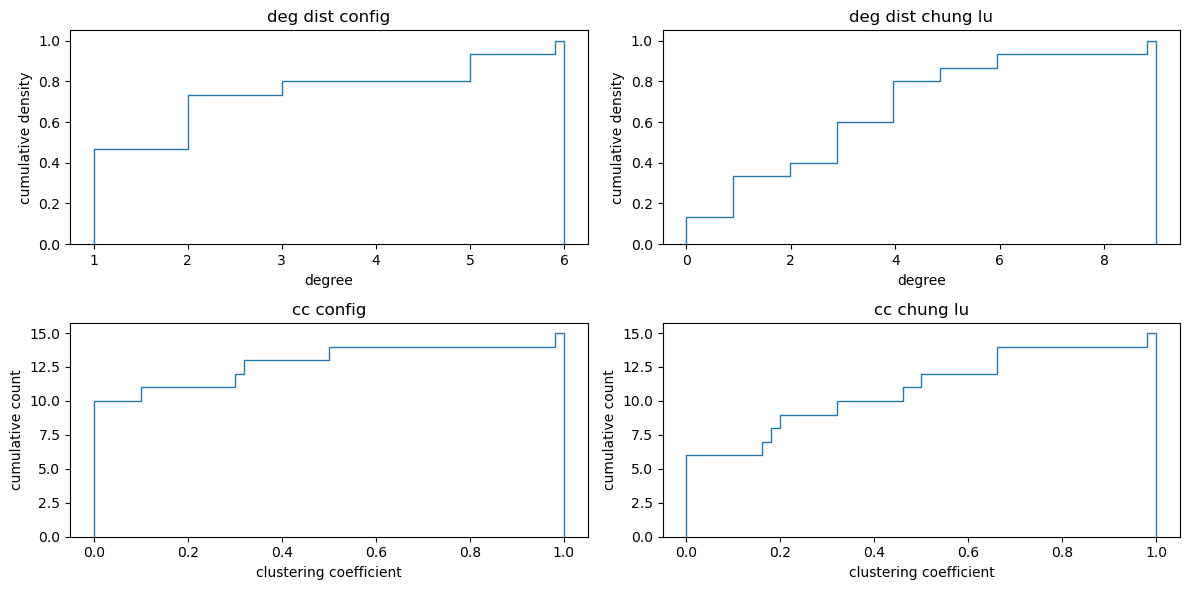

In [31]:
# 1c model diff part 2

# initial setup. creating graphs and collecting data
G_config = config_model(degrees)
G_chunglu = chung_lu(degrees)

config_degrees = [d for _, d in nx.degree(G_config)]
cl_degrees = [d for _, d in nx.degree(G_chunglu)]
config_cc = nx.clustering(G_config)
cl_cc = nx.clustering(G_chunglu)

# creating plots
fig, ax = plt.subplots(2, 2, figsize=(12,6))

# degree distribution on top row in cumulative distribution form
ax[0,0].hist(config_degrees, 
             bins=50, 
             cumulative=True, 
             density=True, 
             histtype='step')
ax[0,0].set_title('deg dist config')
ax[0,0].set_xlabel('degree')
ax[0,0].set_ylabel('cumulative density')

ax[0,1].hist(cl_degrees,
             bins=50,
             cumulative=True,
             density=True,
             histtype='step')
ax[0,1].set_title('deg dist chung lu') 
ax[0,1].set_xlabel('degree')
ax[0,1].set_ylabel('cumulative density')

# clustering coefficient on bottom
ax[1,0].hist(list(config_cc.values()),
             bins=50,
             cumulative=True,
             histtype='step')
ax[1,0].set_title('cc config')
ax[1,0].set_xlabel('clustering coefficient')
ax[1,0].set_ylabel('cumulative count')

ax[1,1].hist(list(cl_cc.values()), 
             bins=50,
             cumulative=True,
             histtype='step')
ax[1,1].set_title('cc chung lu') 
ax[1,1].set_xlabel('clustering coefficient')
ax[1,1].set_ylabel('cumulative count')

fig.tight_layout()

In [35]:
# 2a communities (setup)

G = nx.read_edgelist("C:\\Users\\User\\Documents\\network datasets\\flybrain\\bn-fly-drosophila_medulla_1.edges")

# getting largest connected component
all_components = sorted(nx.connected_components(G), key=len, reverse=True)
main = G.subgraph(all_components[0])

communities = list(nx.community.greedy_modularity_communities(main)) # finding communities
modularity = nx.community.modularity(main, communities) # calculating modularity

print(modularity)
print(len(communities))

# creating partition dict
partition = {}
for community_id, community in enumerate(communities):
    for node_id in community:
        partition[node_id] = community_id

0.37890578479208575
16


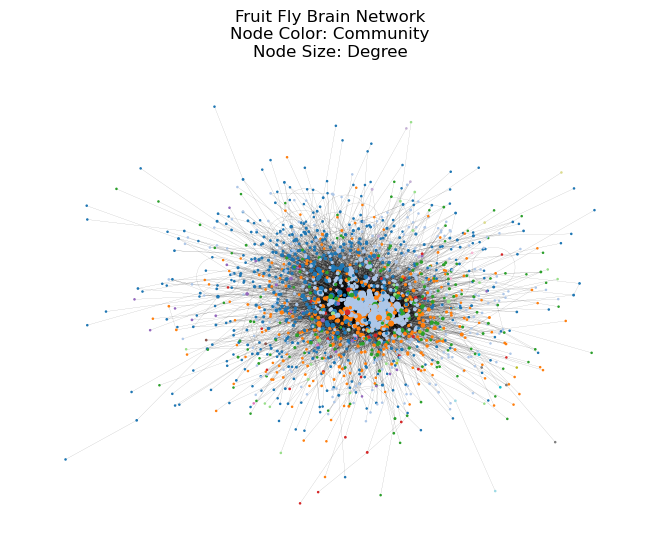

In [36]:
# 2a communities (visualization)

color_map = [partition[node_id] for node_id in main.nodes()] # color mapping
degrees = [d for _, d in main.degree()] # degrees for node sizing

# drawing network with spring layout, color/size for communities and degree respectively
nx.draw_spring(main, 
        with_labels=False,
        node_color=color_map,
        node_size=[0.5 + (v * 0.2) for v in degrees],
        cmap=plt.cm.tab20,
        width=0.05,)

plt.title("Fruit Fly Brain Network\nNode Color: Community\nNode Size: Degree")
plt.show()

In [37]:
# 2b null models

G_null = chung_lu([d for _, d in G.degree()]) #generating null model

# same process as before
null_communities = list(nx.community.greedy_modularity_communities(G_null))
null_modularity = nx.community.modularity(G_null, null_communities)
print(null_modularity)

null_partition = {}
for community_id, community in enumerate(null_communities):
    for node_id in community:
        null_partition[node_id] = community_id

0.23895610053330832


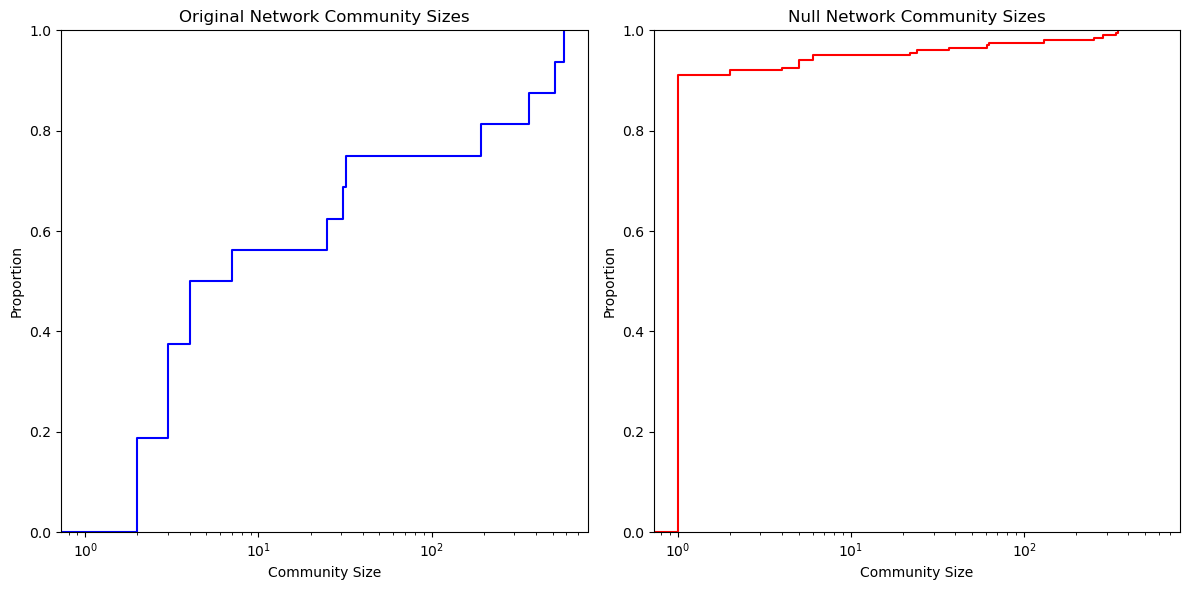

In [43]:
# 2c comparison

# gathering community size data, converting from dict to list
sizedict = Counter(partition.values())
sizelist = list(sizedict.values())
null_sizedict = Counter(null_partition.values())
null_sizelist = list(null_sizedict.values())

# creating plots
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharex=True)

sns.ecdfplot(sizelist, ax=ax[0], color='blue')
ax[0].set_title('Original Network Community Sizes')
ax[0].set_xlabel('Community Size')
ax[0].set_ylabel('Proportion')
ax[0].set_xscale('log')

sns.ecdfplot(null_sizelist, ax=ax[1], color='red')
ax[1].set_title('Null Network Community Sizes')
ax[1].set_xlabel('Community Size')
ax[1].set_ylabel('Proportion')
ax[1].set_xscale('log')

fig.tight_layout()
plt.show()

In [ ]:
# 3i pref attachment (independent probability version)

def preferentialGenerator (n, a):
    ''' 
    Generates a random graph using preferential attachment.

    Args:
        n (int): Number of nodes in the graph.
        a (float or int): Alpha; the exponent in the preferential attachment function.
    '''
    # handle a < 0 edge case
    if a < 0:
        print("Error: alpha must not be negative.")
        return None
    
    G = nx.Graph()
    G.add_node(0)

    for i in range(1, n):
        existing_nodes = list(range(i)) # existing nodes are all nodes less than i
        G.add_node(i)
        denominator = sum([G.degree(m)**a + 1 for m in existing_nodes]) # denominator calculation
        for j in existing_nodes:
            numerator = G.degree(j)**a + 1 # numerator calculation
            if denominator == 0: # correctly handle "ZeroDivisionError"
                p = 0 
            else:
                p = numerator / denominator
            if random.random() < p:
                G.add_edge(i, j) 
    return G

In [3]:
# 3i pref attachment (m=1 version)

def preferentialGenerator (n, a):
    ''' 
    Generates a random graph using preferential attachment with m=1.

    Args:
        n (int): Number of nodes in the graph.
        a (float or int): Alpha; the exponent in the preferential attachment function.
    '''
    # handle a < 0 edge case
    if a < 0:
        print("Error: alpha must not be negative.")
        return None
    
    # start with a single node
    G = nx.Graph()
    G.add_node(0)

    # loop to add the remaining n-1 nodes
    for i in range(1, n):
        G.add_node(i) # new node to be added
        existing_nodes = list(range(i))
        # calculate the numerator for all existing nodes at once
        weights = [G.degree(j)**a + 1 for j in existing_nodes]
        # choose node to connect to
        target_node = random.choices(existing_nodes, weights=weights, k=1)[0]
        G.add_edge(i, target_node)
    return G

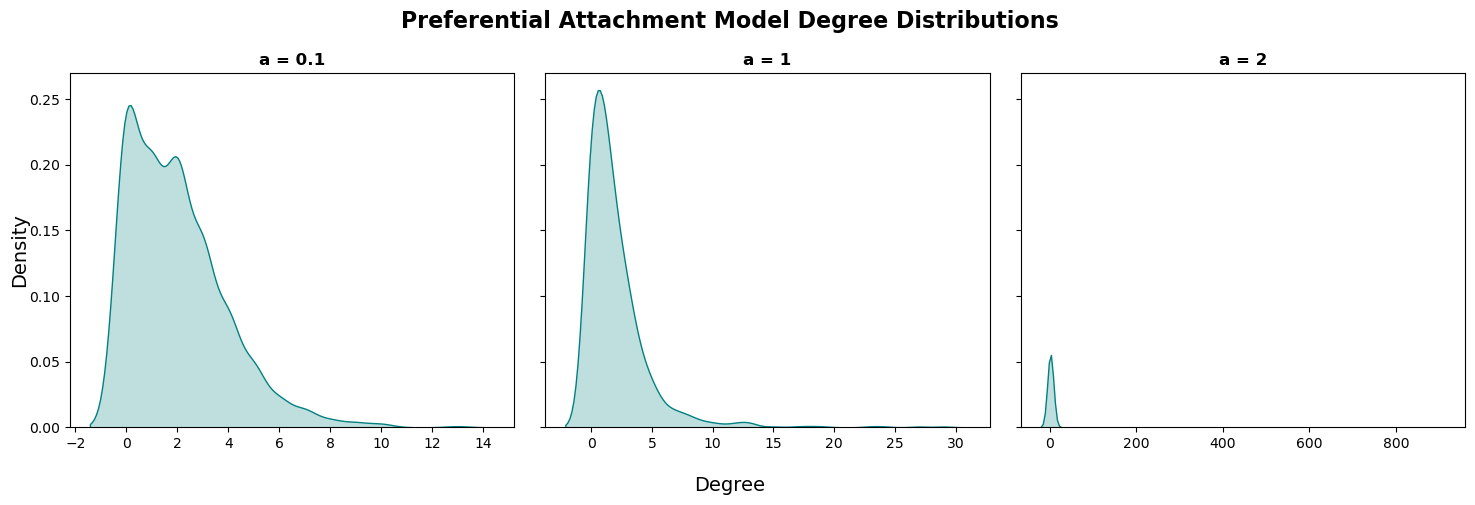

In [ ]:
# 3ii degree analysis

# creating networks
a01 = preferentialGenerator(1000, .01)
a1 = preferentialGenerator(1000, 1)
a2 = preferentialGenerator(1000, 2)

# plotting
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True) # sharing y axis
fig.supxlabel("Degree", fontsize=14)
fig.supylabel("Density", fontsize=14)
color='teal' # setting color

# list comp for data
sns.kdeplot([d for _, d in a01.degree()], fill=True, ax=ax[0], color=color)
sns.kdeplot([d for _, d in a1.degree()], fill=True, ax=ax[1], color=color)
sns.kdeplot([d for _, d in a2.degree()], fill=True, ax=ax[2], color=color)

ax[0].set_title('a = 0.1', fontweight='bold')
ax[0].set_ylabel('') # removing sns default y label (works for all since sharey=True)
ax[1].set_title('a = 1', fontweight='bold')
ax[2].set_title('a = 2', fontweight='bold')

# title and finishing touches
plt.suptitle("Preferential Attachment Model Degree Distributions", fontweight='bold', size=16)
fig.tight_layout()
plt.show()

In [47]:
# 3iii random walk

def randomWalkGenerator(n, p):
    G = nx.Graph()
    G.add_node(0)

    # section to deal with n=1 edge case
    if n == 1:
        return G
    G.add_edge(0, 1)

    for i in range(2, n):
        existing_nodes = list(range(i))
        G.add_node(i)
        j = random.choice(existing_nodes) # choosing random existing node
        G.add_edge(i, j)
        x = random.choice(existing_nodes) # choosing another random existing node
        if random.random() < p:
            j_neighbors = list(G.neighbors(j))
            j_neighbors.remove(i) # avoiding connection to i itself
            if len(j_neighbors) > 0:
                v = random.choice(j_neighbors)
                G.add_edge(i, v)
            else:
                G.add_edge(i, x) # fallback to random node if no valid neighbors
        else:
            G.add_edge(i, x) # adding to a different random node
    return G

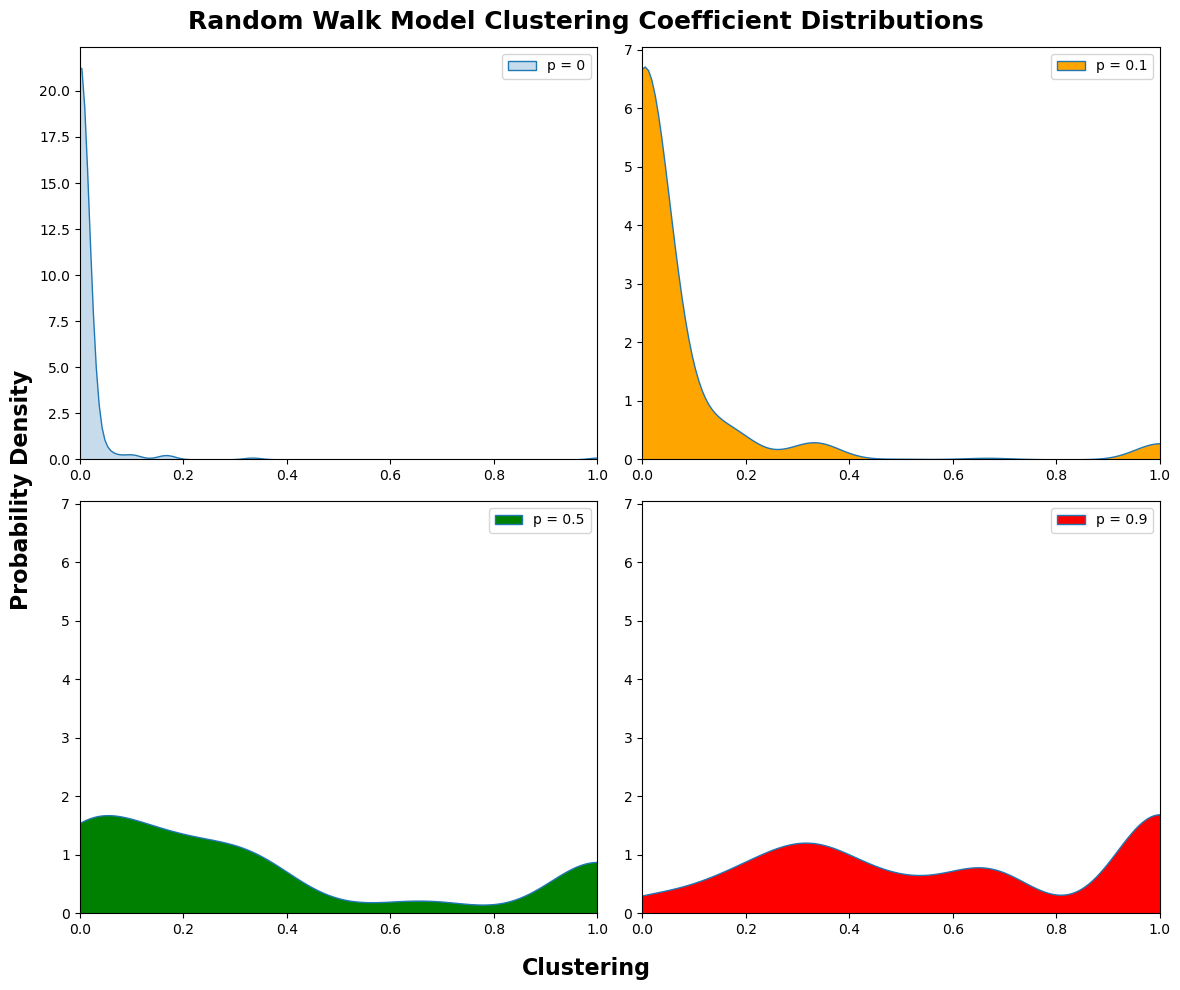

In [ ]:
# 3iv clustering analysis

# creating networks
n = 1000
G_rw0 = randomWalkGenerator(n, 0)
G_rw01 = randomWalkGenerator(n, 0.1)
G_rw05 = randomWalkGenerator(n, 0.5)
G_rw09 = randomWalkGenerator(n, 0.9)

# plotting
fig, ax = plt.subplots(2, 2, figsize=(12,10), sharex=True)
fig.supxlabel("Clustering", fontweight='bold', size=16)
fig.supylabel("Probability Density" , fontweight='bold', size=16)

# only share y for last three plots since p=0 puts all clustering at 0
ax[1,0].sharey(ax[0,1])
ax[1,1].sharey(ax[0,1])

# making x-axis labels visible on all plots
ax[0,0].tick_params(axis='x', labelbottom=True)
ax[0,1].tick_params(axis='x', labelbottom=True)

# filling plots with data
sns.kdeplot(dict(nx.clustering(G_rw0)).values(), fill=True, ax=ax[0,0],
            label='p = 0')
ax[0,0].legend()
ax[0,0].set_ylabel('') # removing sns default y labels
sns.kdeplot(dict(nx.clustering(G_rw01)).values(), fill=True, ax=ax[0,1],
            label='p = 0.1', facecolor='orange') # facecolor to switch things up
ax[0,1].legend()
ax[0,1].set_ylabel('')
sns.kdeplot(dict(nx.clustering(G_rw05)).values(), fill=True, ax=ax[1,0],
            label='p = 0.5', facecolor='green')
ax[1,0].legend()
ax[1,0].set_ylabel('')
sns.kdeplot(dict(nx.clustering(G_rw09)).values(), fill=True, ax=ax[1,1],
            label='p = 0.9', facecolor='red')
ax[1,1].legend()
ax[1,1].set_ylabel('')

plt.suptitle("Random Walk Model Clustering Coefficient Distributions", fontweight='bold', size=18)
plt.xlim(0, 1) # force x-axis from 0 to 1, applies to all due to sharex
fig.tight_layout()
plt.show()